In [1]:
import os
import glob
import shutil
import time

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler

import eli5
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from eli5.sklearn import PermutationImportance

C:\Users\Ebarnes\AppData\Local\Continuum\anaconda3\envs\tflow\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Ebarnes\AppData\Local\Continuum\anaconda3\envs\tflow\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Pull in CSVs
all_hexagons = pd.read_csv("all_hexagons_50c_grouped_withCounties.csv")
records = pd.read_csv("june29_1589_records.csv")

all_hexagons.set_index('subwatershed', inplace=True)

# Join data frames to make master file. Join key = 'subwatershed'
joined = records.join(all_hexagons, on='subwatershed')

In [3]:
# Drop columns not needed.
# Comment out a line to leave in for processing.
drop_list = [
    'Unnamed: 0',       # Always remove
    # 'area',
    'perimeter',
    'circulatory_ratio',
    # 'relief',
    # 'avg_slope',
    'watershed_length',
    'elongation_ratio',
    # 'drainage_density',
    'shape_factor',
    # 'relief_ratio',
    # 'ruggedness',
    # 'aae_area',
    # 'buildings_aae_count',
    'x_area',
    'buildings_x_count',
    # 'water_bodies_area',
    'dams_count',
    'bridges_count',
    'streets_km',
    'railroads_km',
    # 'population',
    # 'population_density',
    # 'avg_median_income',
    # 'housing_density',
    'population_change',
    'dependent_population_pct',
    'dist_to_stream_avg..m.',
    'dist_to_stream_stdev..m.',
    # 'lu_22_area',
    # 'lu_23_area',
    # 'lu_24_area',
    # 'lu_41_area',
    # 'lu_82_area',
    # 'avg_impervious_percent',
    # 'orb100yr06h',
    # 'orb100yr12h',
    # 'orb100yr24h',
    # 'orb25yr06h',
    # 'orb25yr12h',
    # 'orb25yr24h',
    # 'orb2yr06h',
    # 'orb2yr12h',
    # 'orb2yr24h',
    # 'orb50yr06h',
    # 'orb50yr12h',
    # 'orb50yr24h',
    # 'orb100yr06ha_am',
    # 'orb100yr12ha_am',
    # 'orb100yr24ha_am',
    # 'orb25yr06ha_am',
    # 'orb25yr12ha_am',
    # 'orb25yr24ha_am',
    # 'orb2yr06ha_am',
    # 'orb2yr12ha_am',
    # 'orb2yr24ha_am',
    # 'orb50yr06ha_am',
    # 'orb50yr12ha_am',
    # 'orb50yr24ha_am',
    # 'policy_total_building_coverage_avg',
    'File'          # Always remove
]

# Drop columns in 'drop_list'
joined.drop(
    drop_list,
    axis=1,
    inplace=True
)

In [4]:
# Drop 'bad data'
joined = joined[joined['subwatershed'] != 41900000200]
# Drop rows with blanks
joined = joined.dropna()

In [5]:
# Create directory
folder_name = moyr = time.strftime("%Y%m%d_%H.%M.%S")
try:
    os.mkdir('Runs/{}'.format(folder_name))
    out_directory = os.path.join('Runs', folder_name)
except OSError:
    print('Something went wrong')
    
# Save the joined data to csv
joined.to_csv(os.path.join(out_directory, 'joined_data.csv'))

In [6]:
# Normalize the rows to 0-1, excluding the watershed identifier
scaler = MinMaxScaler(feature_range=(0, 1))
column_list = list(joined.columns)
column_list.remove('subwatershed')

joined[column_list] = scaler.fit_transform(joined[column_list])

scaler_by = scaler.scale_[44]
scaler_min = scaler.min_[44]

print("Note: {} values were scaled by multiplying by {:.12f} and adding {:.10f}".format(
    column_list[44],
    scaler_by,
    scaler_min)
)

Note: claims_total_building_insurance_coverage_avg values were scaled by multiplying by 0.000005938390 and adding 0.0000000000


In [7]:
# REMOVED UNTIL 0s FOR MONETARY CLAIMS VALUES CAN BE ACCOUNTED FOR
# i_rows = len(joined)
# print('Initial row count for data: ' + str(i_rows))
# usable_data = joined[(np.abs(stats.zscore(joined)) < 3).all(axis=1)]
# u_rows = len(usable_data)
# print("- Identified and removed {} outliers.".format(str(i_rows-u_rows)))
# print('Updated row count for all data: ' + str(u_rows))

In [8]:
joined.to_csv(os.path.join(out_directory, 'final_data_scaled.csv'))

In [9]:
# Use 70% of the data for training, 15% for testing, 15% for validation.
# Subset data for training, testing, validation
training_df = joined.sample(frac=.7, random_state=663168)
testing_df = joined.loc[~joined.index.isin(training_df.index)]
validation_df = testing_df.sample(frac=.5, random_state=663168)
testing_df = testing_df.loc[~testing_df.index.isin(validation_df.index)]

# Save subsets
training_df.to_csv(os.path.join(out_directory, 'training_data.csv'))
testing_df.to_csv(os.path.join(out_directory, 'testing_data.csv'))
validation_df.to_csv(os.path.join(out_directory, 'validation_data.csv'))

In [10]:
# Print number of input nodes for network
# Number of columns minus 2 (subwatershed, Unnamed: 0)
node_count = int(len(list(training_df.columns)) - 2)
print('Number of input nodes: ' + str(node_count))

Number of input nodes: 44


In [11]:
testing_df.head()

,subwatershed,area,relief,avg_slope,drainage_density,relief_ratio,ruggedness,aae_area,buildings_aae_count,water_bodies_area,...,orb25yr12ha_am,orb25yr24ha_am,orb2yr06ha_am,orb2yr12ha_am,orb2yr24ha_am,orb50yr06ha_am,orb50yr12ha_am,orb50yr24ha_am,policy_total_building_coverage_avg,claims_total_building_insurance_coverage_avg
0,51202081102,0.243358,0.378698,0.288488,0.392892,0.098036,0.287301,0.042732,0.001619,0.143892,...,0.987940,0.980584,0.993346,0.992129,0.991740,0.981242,0.977147,0.969626,0.073643,0.000052
3,51201060507,0.150076,0.207101,0.088759,0.253569,0.033752,0.102256,0.042320,0.000000,0.009118,...,0.964293,0.942513,0.980697,0.972571,0.962983,0.964448,0.954616,0.930608,0.185490,0.168501
15,51202040504,0.509819,0.171598,0.071934,0.334641,0.019514,0.111178,0.170369,0.070677,0.050858,...,0.962667,0.934772,0.978561,0.975990,0.970784,0.960385,0.950174,0.916141,0.574306,0.245618
18,71200011009,0.203096,0.289941,0.095203,0.353065,0.021366,0.198009,0.010314,0.002967,0.014987,...,0.980961,0.974619,0.980450,0.974002,0.967036,0.986456,0.978434,0.971967,0.344624,0.264531
20,41000050104,0.195222,0.224852,0.074073,0.445955,0.031276,0.193271,0.039827,0.014297,0.009195,...,0.936920,0.910787,0.963282,0.954524,0.943250,0.933839,0.925068,0.896272,0.327946,0.447794


In [12]:
# Format the training data set
training_df.drop(['subwatershed'], axis=1, inplace=True)

# Create column list for feature importance chart
column_list = training_df.drop('claims_total_building_insurance_coverage_avg', axis=1).columns.tolist()

# Format the separate test data set
testing_df.drop(['subwatershed'], axis=1, inplace=True)

# Format the validation data
validation_df.drop(['subwatershed'], axis=1, inplace=True)

In [13]:
# Predicting 'claims_total_building_insurance_coverage_avg'
prediction_column = 'claims_total_building_insurance_coverage_avg'

# Format training data
x_train = training_df.drop(prediction_column, axis=1).values
y_train = training_df[prediction_column].values

# Format the testing data
x_test = testing_df.drop(prediction_column, axis=1).values
y_test = testing_df[prediction_column].values

# Format the validation data
x_validate = validation_df.drop(prediction_column, axis=1).values
y_validate = validation_df[prediction_column].values

In [14]:
# Define the model
def base_model(input_nodes=44):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(86, input_dim=input_nodes, activation='relu', name='Initial'))
    model.add(tf.keras.layers.Dropout(.2, name='Dropout_1'))
    model.add(tf.keras.layers.Dense(172, activation='relu', name='Dense_2'))
    model.add(tf.keras.layers.Dropout(.2, name='Dropout_2'))
    model.add(tf.keras.layers.Dense(86, activation='relu', name='Dense_3'))
    model.add(tf.keras.layers.Dropout(.2, name='Dropout_3'))
    model.add(tf.keras.layers.Dense(1, activation='linear', name='Output'))
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model


epochs = 30

In [15]:
# Log with TensorBoard
logger = tf.keras.callbacks.TensorBoard(
    log_dir='logs',
    write_graph=True,
    histogram_freq=3
)

In [16]:
# Define model parameters with KerasRegressor
my_model = KerasRegressor(
    build_fn=base_model,
    input_nodes=44,
    epochs=epochs
)

In [17]:
# Train the model
history = my_model.fit(
    x_train,
    y_train,
    validation_data=(x_validate, y_validate),
    epochs=epochs,
    shuffle=False,
    verbose=2,
    callbacks=[logger]
)

Train on 1102 samples, validate on 236 samples
Epoch 1/30
1102/1102 - 1s - loss: 0.0336 - val_loss: 0.0113
Epoch 2/30
1102/1102 - 0s - loss: 0.0161 - val_loss: 0.0115
Epoch 3/30
1102/1102 - 0s - loss: 0.0145 - val_loss: 0.0112
Epoch 4/30
1102/1102 - 0s - loss: 0.0137 - val_loss: 0.0100
Epoch 5/30
1102/1102 - 0s - loss: 0.0132 - val_loss: 0.0098
Epoch 6/30
1102/1102 - 0s - loss: 0.0128 - val_loss: 0.0101
Epoch 7/30
1102/1102 - 0s - loss: 0.0123 - val_loss: 0.0096
Epoch 8/30
1102/1102 - 0s - loss: 0.0122 - val_loss: 0.0091
Epoch 9/30
1102/1102 - 0s - loss: 0.0114 - val_loss: 0.0088
Epoch 10/30
1102/1102 - 0s - loss: 0.0110 - val_loss: 0.0088
Epoch 11/30
1102/1102 - 0s - loss: 0.0111 - val_loss: 0.0088
Epoch 12/30
1102/1102 - 0s - loss: 0.0107 - val_loss: 0.0088
Epoch 13/30
1102/1102 - 0s - loss: 0.0109 - val_loss: 0.0088
Epoch 14/30
1102/1102 - 0s - loss: 0.0106 - val_loss: 0.0087
Epoch 15/30
1102/1102 - 0s - loss: 0.0112 - val_loss: 0.0088
Epoch 16/30
1102/1102 - 0s - loss: 0.0111 - val

In [18]:
perm = PermutationImportance(my_model, random_state=1).fit(x_train, y_train)
weights = eli5.explain_weights(perm, feature_names=column_list)
weights_dict = eli5.formatters.as_dict.format_as_dict(weights)

1102/1102 [==============================] - 0s 21us/sample - loss: 0.0128


In [19]:
# Collect a dataframe of weight data
weights_df = pd.DataFrame()
weights_df['feature'] = list(thisdict['feature'] for thisdict in weights_dict['feature_importances']['importances'])
weights_df['weight'] = list(thisdict['weight'] for thisdict in weights_dict['feature_importances']['importances'])
weights_df['Std Dev'] = list(thisdict['std'] for thisdict in weights_dict['feature_importances']['importances'])
weights_df['Value'] = list(thisdict['value'] for thisdict in weights_dict['feature_importances']['importances'])

In [20]:
train_mse = my_model.score(x_train, y_train, verbose=0)
test_mse = my_model.score(x_test, y_test, verbose=0)

# Store true MSE values, calculate RMSE values
train_mse = abs(train_mse)
test_mse = abs(test_mse)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Mean squared error (MSE) values:')
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
print('Train RMSE: %.3f, Test RMSE: %.3f' % (train_rmse, test_rmse))

Mean squared error (MSE) values:
Train: 0.009, Test: 0.011
Train RMSE: 0.097, Test RMSE: 0.103


In [21]:
# Move the logs to the appropriate dir
# Visualize through terminal:
# C:\Users\Ebarnes\Desktop\Projects\ML_Indiana_test> tensorboard --logdir=Runs\()\logs
shutil.move('logs', out_directory)
print("Vizualize in Conda:\nC:\\Users\\Ebarnes\\Documents\\GitHub\\machine_learning\\ML_Indiana>\ntensorboard --logdir={}\\logs".format(out_directory))

Vizualize in Conda:
C:\Users\Ebarnes\Documents\GitHub\machine_learning\ML_Indiana>
tensorboard --logdir=Runs\20200630_17.38.19\logs


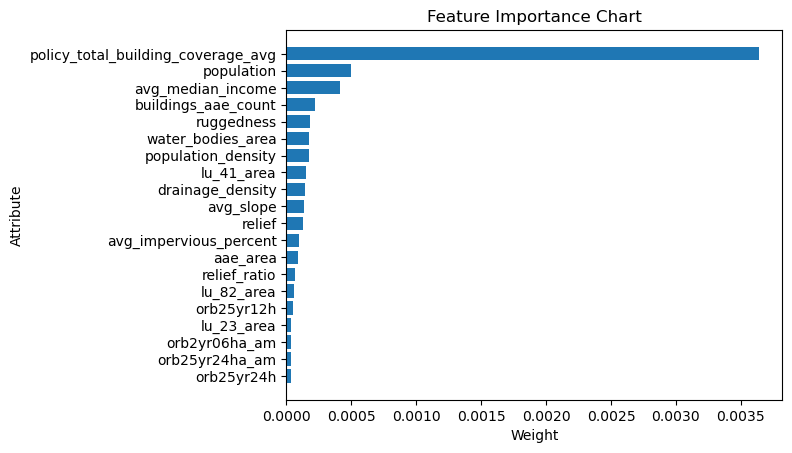

In [22]:
# Plot item weights
features = weights_df['feature'].tolist()
weights = weights_df['weight']
y_pos = np.arange(len(features))
pyplot.rcdefaults()
fig, ax = pyplot.subplots()
ax.barh(y_pos, weights, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.set_ylabel('Attribute')
ax.invert_yaxis()
ax.set_xlabel('Weight')
ax.set_title('Feature Importance Chart')
pyplot.savefig((out_directory + '/weights_plot.png'), bbox_inches='tight')
pyplot.show()

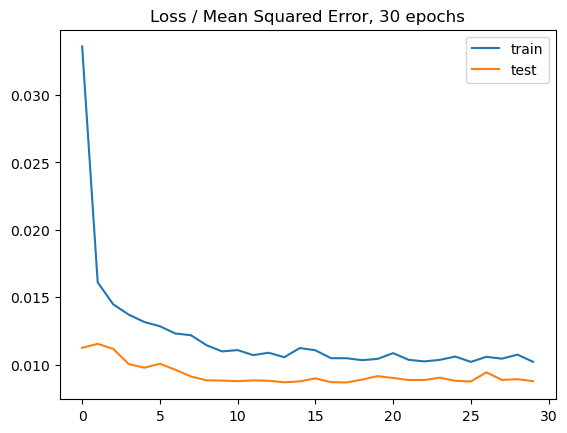

In [23]:
# Plot loss during training
pyplot.title('Loss / Mean Squared Error, {} epochs'.format(str(epochs)))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig((out_directory + '/loss_plot.png'))
pyplot.show()

In [24]:
# Save training, validation, testing data and model
training_df.to_csv(os.path.join(out_directory, '/training_data.csv'))
validation_df.to_csv(os.path.join(out_directory, '/validation_data.csv'))
testing_df.to_csv(os.path.join(out_directory, '/testing_data.csv'))
my_model.model.save(os.path.join(out_directory, '/trained_model.h5'))
print('Model saved to disk.')

Model saved to disk.


In [25]:
# Chi squared analysis
predictions = my_model.predict(x_test)

# Scale data back to original form:
predictions = predictions / scaler_by
predictions = predictions - scaler_min
y_test = y_test / scaler_by
y_test = y_test - scaler_min

predicted = pd.Series(predictions)
actual = pd.Series(y_test)

chi_square_df = pd.DataFrame()
chi_square_df['predicted'] = predicted
chi_square_df['actual'] = actual

chi_square = stats.chisquare(chi_square_df['predicted'].tolist(), chi_square_df['actual'].tolist())

C:\Users\Ebarnes\AppData\Local\Continuum\anaconda3\envs\tflow\lib\site-packages\scipy\stats\stats.py:5745: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
